<a href="https://colab.research.google.com/github/AshwinUnnikrishnan/DeepLearning7150/blob/main/LearnPytorch/LearningAFourLayerPerceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
# If you are on Google Colab, this sets up everything needed.
# If not, you will want to pip install the cs7150lib as shown below.
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install git+https://github.com/cs7150/cs7150lib@main

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cs7150/cs7150lib (to revision main) to /tmp/pip-req-build-_8ibqign
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Cloning https://github.com/davidbau/baukit (to revision main) to /tmp/pip-install-l0kp94d7/baukit_9c0528bdfabf40668021b3119edf973f
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: sta

  Running command git clone -q https://github.com/cs7150/cs7150lib /tmp/pip-req-build-_8ibqign
  Running command git clone -q https://github.com/davidbau/baukit /tmp/pip-install-l0kp94d7/baukit_9c0528bdfabf40668021b3119edf973f


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CS7150/cs7150lib/blob/main/notebooks/LearningAFourLayerPerceptron.ipynb)

# Learning a four-layer perceptron

We learned in Lecture 1 that Rosenblatt's Perceptron was limited because it only learned one layer.  It was a *shallow* learning architecture.

We want to learn *deep* layers.

To do it, we start with the simple idea from [Rumelhart 1986](https://papers.baulab.info/Rumelhart-1986.pdf): use *derivatives* to figure out the updates.

This works surprisingly well, but it can fail if the derivatives get too big or too small, for example, if the network has too many layers.  We will explore these situations in this notebook.

This notebook is designed to be able to work on Google colab.


In [2]:
import torch, numpy
from collections import OrderedDict
from copy import deepcopy
from torch.nn import Sequential, Linear, ReLU, Sigmoid, Tanh
from matplotlib import pyplot as plt
from cs7150 import seeded_net, non_linearly_separable_data, Sign
from cs7150 import MLPHistoryWidget, LossSurfaceWidget
from baukit import show, pbar

# Adding more layers to Rosenblatt's setup

The original perceptron would have had one trainable neuron with an input weight for the horizontal position of a dot, and a second input weight for the vertical position of the dot.  In other words, it would have had a two-dimenaional input.

We will make the setup more powerful by adding three more trainable layers before this last neuron.  Each layer will take two inputs and produce two outputs, as illustrated here:

<img src="https://cs7150.baulab.info/2022-Fall/colab/mlp-architecture.png">

The code is below.

## Exercise 1.  Run the multilayer perceptron.

Run the multilayer perceptron below, without changing any code.

Look at the training curve after 1000 steps.  What (doesn't) happen?

**That is because the derivatives are always zero.  You will fix this in Exercise 2.**


*   Why do we need to specify first column in result




In [3]:
# For Exercise 1, just read and run the code.
data, labels = non_linearly_separable_data()

mlp = torch.nn.Sequential(OrderedDict([
    ('layer1', Sequential(Linear(2, 2), Sign())),
    ('layer2', Sequential(Linear(2, 2), Sign())),
    ('layer3', Sequential(Linear(2, 2), Sign())),
    ('layer4', Sequential(Linear(2, 1), Sign()))
]))
seeded_net(1, mlp) # Seed the parameters pseudorandomly

history = []
learning_rate = 0.01
for iteration in pbar(range(1000)):
    preds = mlp(data)[:,0]
    loss = ((preds - labels) ** 2).mean()
    grads = torch.autograd.grad(loss, mlp.parameters())
  
    with torch.no_grad():
        accuracy = (preds.sign() == labels).sum().item() / len(labels)
        # Remember a history of network weights, losses, and accuracies
        history.append((deepcopy(mlp), dict(loss=loss.item(), accuracy=accuracy)))
        # Update the network parameters
        for (name, parameter), grad in zip(mlp.named_parameters(), grads):
            parameter -= learning_rate * grad
# Visualize the history.
MLPHistoryWidget(data=data, labels=labels, history=history)

## Exercise 2.  Make the network differentiable using Tanh().

Copy the Exercise 1 code into the cell below, and then edit it so that instead of using the Sign() step nonlinearity, the network uses the Tanh() sigmoid nonlinearity.  Try things again.  What's the difference?

What accuracy is achieved in 1000 training iterations?

Do not train the network to a global optimum yet, because we will want to visualize a splot on a non-optimized loss surface in Exercise 3.

In [4]:
# For Exercise 1, just read and run the code.
data, labels = non_linearly_separable_data()

mlp = torch.nn.Sequential(OrderedDict([
    ('layer1', Sequential(Linear(2, 2), Tanh())),
    ('layer2', Sequential(Linear(2, 2), Tanh())),
    ('layer3', Sequential(Linear(2, 2), Tanh())),
    ('layer4', Sequential(Linear(2, 1), Tanh()))
]))
seeded_net(1, mlp) # Seed the parameters pseudorandomly

history = []
learning_rate = 0.01
for iteration in pbar(range(1000)):
    preds = mlp(data)[:,0]
    loss = ((preds - labels) ** 2).mean()
    grads = torch.autograd.grad(loss, mlp.parameters())
  
    with torch.no_grad():
        accuracy = (preds.sign() == labels).sum().item() / len(labels)
        # Remember a history of network weights, losses, and accuracies
        history.append((deepcopy(mlp), dict(loss=loss.item(), accuracy=accuracy)))
        # Update the network parameters
        for (name, parameter), grad in zip(mlp.named_parameters(), grads):
            parameter -= learning_rate * grad
# Visualize the history.
MLPHistoryWidget(data=data, labels=labels, history=history)

## Exercise 3. Visualize the loss surface.

The following code prints every individual scalar parameter in the model.  There are 21 parameters.

Your task is to visualize the loss surface by plotting the 21 loss curves when each individual parameter is offset by -10.0 to +10.0

In [5]:
import torch, numpy

with torch.no_grad():
    for name, param in mlp.named_parameters():
      print(f'{name or "The whole network"} is a {type(param).__name__}')

layer1.0.weight is a Parameter
layer1.0.bias is a Parameter
layer2.0.weight is a Parameter
layer2.0.bias is a Parameter
layer3.0.weight is a Parameter
layer3.0.bias is a Parameter
layer4.0.weight is a Parameter
layer4.0.bias is a Parameter


In [6]:
with torch.no_grad():
    for name, param in mlp.named_parameters():
        for index in numpy.ndindex(param.shape):
            original_w = param[index].detach().item()
            print(f'Value of {name}{index}', original_w)

Value of layer1.0.weight(0, 0) 1.5964823961257935
Value of layer1.0.weight(0, 1) -0.8696092963218689
Value of layer1.0.weight(1, 0) -0.4704257547855377
Value of layer1.0.weight(1, 1) -1.027929425239563
Value of layer1.0.bias(0,) 0.7955907583236694
Value of layer1.0.bias(1,) -2.3564624786376953
Value of layer2.0.weight(0, 0) 2.009960412979126
Value of layer2.0.weight(0, 1) -0.4366540312767029
Value of layer2.0.weight(1, 0) 0.3515244424343109
Value of layer2.0.weight(1, 1) -0.25935256481170654
Value of layer2.0.bias(0,) 1.1960067749023438
Value of layer2.0.bias(1,) -2.043166399002075
Value of layer3.0.weight(0, 0) -0.33288460969924927
Value of layer3.0.weight(0, 1) -0.38389328122138977
Value of layer3.0.weight(1, 0) 1.214623212814331
Value of layer3.0.weight(1, 1) -0.9973911046981812
Value of layer3.0.bias(0,) -0.169709712266922
Value of layer3.0.bias(1,) -0.9911563396453857
Value of layer4.0.weight(0, 0) -0.08803124725818634
Value of layer4.0.weight(0, 1) 1.099019169807434
Value of laye

The following code shows the loss curve varying just two of the parameters.


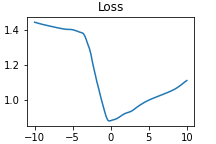
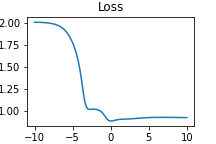

In [7]:
index = (0, 0)
offsets = torch.linspace(-10.0, 10.0, 101)
results = []
with torch.no_grad():
    for param in [mlp.layer1[0].weight, mlp.layer2[0].weight]:
        losses = []
        original_w = param[index].detach().item()
        for offset in offsets:
            param[index] = original_w + offset
            preds = mlp(data)[:,0]
            loss = ((preds - labels) ** 2).mean()
            losses.append(loss.item())
        param[index] = original_w
        fig, ax = plt.subplots(figsize=(3,2))
        ax.set_title(f'Loss')
        ax.plot(offsets, losses)
        results.append(fig)
        plt.close()
show([results])


Now, with the two examples above in mind, make a function called `show_loss_surface` that takes `mlp` as an argument, and then shows loss curves for all 21 parameters, labeling each graph with the name of the parameter.


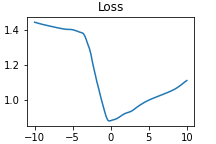
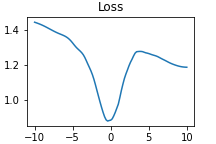
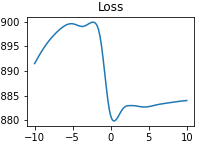
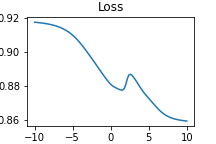
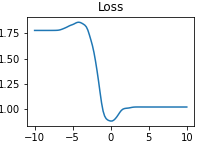
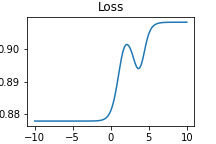
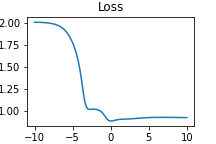
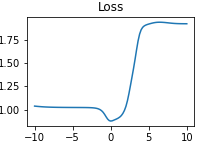
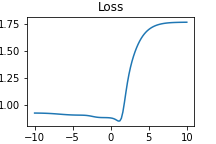
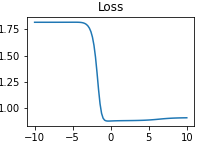
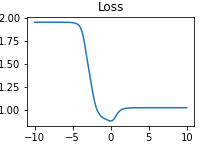
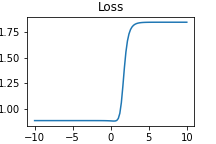
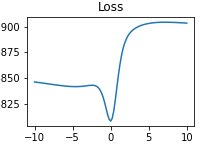
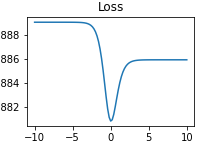
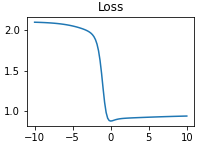
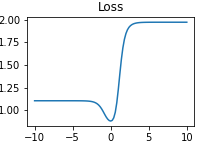
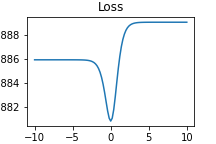
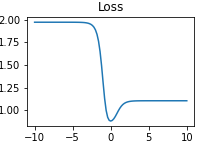
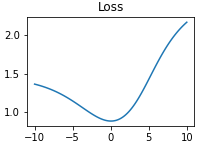
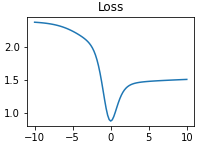
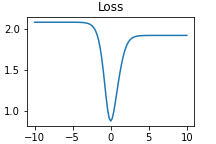

In [8]:
# Your code for Exercise 3 here.
def show_loss_surfaces(mlp):
  offsets = torch.linspace(-10.0, 10.0, 101)
  results = []

  with torch.no_grad():
    for name, param in mlp.named_parameters():
        for index in numpy.ndindex(param.shape):
            losses = []
            original_w = param[index].detach().item()
            for offset in offsets:
                param[index] = original_w + offset
                preds = mlp(data)[:,0]
                loss = ((preds - labels) ** 2).mean()
                losses.append(loss.item())
            param[index] = original_w
            fig, ax = plt.subplots(figsize=(3,2))
            ax.set_title(f'Loss')
            ax.plot(offsets, losses)
            results.append(fig)
            plt.close()
    show([results])
show_loss_surfaces(mlp)

You can also use `LossSurfaceWidget(mlp)` to visualize the interaction between two parameters at once.  Use this to visualize some pairs of parameters.

## Exercise 4. Adjust the learning rate to find a global optimum.

Copy the Exercise 2 code again, and adjust the learning rate to speeds up training.

Try to find a solution that looks like a global optimum, and now plot the loss curves using `show_loss_surface` again.  Does the result look more like a global optimium?

Now change the seed, and look for a case that gets stuck before reaching an optimum, and visualize it.

In [9]:
data, labels = non_linearly_separable_data()

mlp = torch.nn.Sequential(OrderedDict([
    ('layer1', Sequential(Linear(2, 2), Tanh())),
    ('layer2', Sequential(Linear(2, 2), Tanh())),
    ('layer3', Sequential(Linear(2, 2), Tanh())),
    ('layer4', Sequential(Linear(2, 1), Tanh()))
]))
seeded_net(1, mlp) # Seed the parameters pseudorandomly

history = []
learning_rate = 0.4
for iteration in pbar(range(1000)):
    preds = mlp(data)[:,0]
    loss = ((preds - labels) ** 2).mean()
    grads = torch.autograd.grad(loss, mlp.parameters())
  
    with torch.no_grad():
        accuracy = (preds.sign() == labels).sum().item() / len(labels)
        # Remember a history of network weights, losses, and accuracies
        history.append((deepcopy(mlp), dict(loss=loss.item(), accuracy=accuracy)))
        # Update the network parameters
        for (name, parameter), grad in zip(mlp.named_parameters(), grads):
            parameter -= learning_rate * grad
# Visualize the history.
MLPHistoryWidget(data=data, labels=labels, history=history)


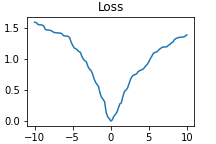
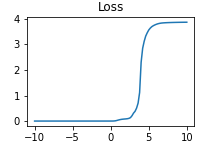
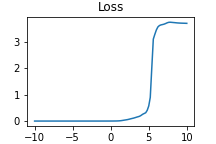
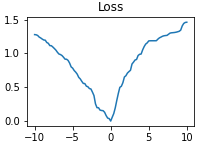
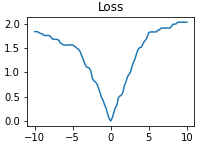
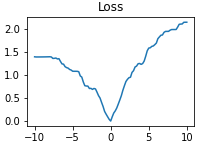
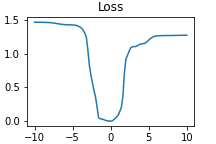
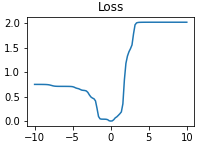
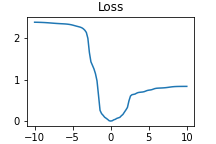
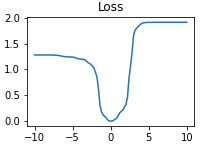
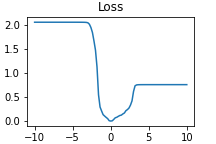
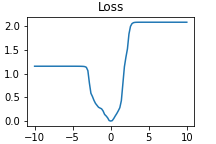
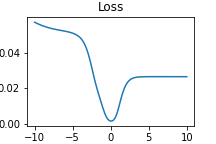
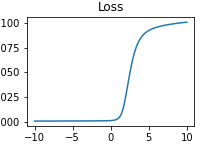
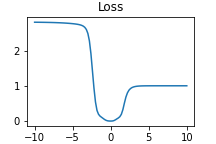
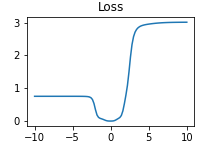
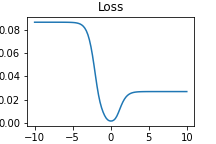
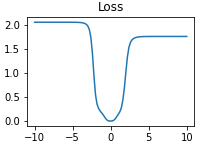
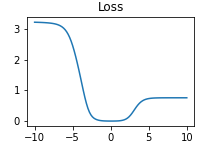
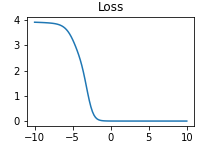
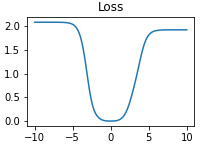

In [10]:
show_loss_surfaces(mlp)

Changing the seed to 4

In [11]:
# For Exercise 1, just read and run the code.
data, labels = non_linearly_separable_data()

mlp = torch.nn.Sequential(OrderedDict([
    ('layer1', Sequential(Linear(2, 2), Tanh())),
    ('layer2', Sequential(Linear(2, 2), Tanh())),
    ('layer3', Sequential(Linear(2, 2), Tanh())),
    ('layer4', Sequential(Linear(2, 1), Tanh()))
]))
seeded_net(4, mlp) # Seed the parameters pseudorandomly

history = []
learning_rate = 0.1
for iteration in pbar(range(1000)):
    preds = mlp(data)[:,0]
    loss = ((preds - labels) ** 2).mean()
    grads = torch.autograd.grad(loss, mlp.parameters())
  
    with torch.no_grad():
        accuracy = (preds.sign() == labels).sum().item() / len(labels)
        # Remember a history of network weights, losses, and accuracies
        history.append((deepcopy(mlp), dict(loss=loss.item(), accuracy=accuracy)))
        # Update the network parameters
        for (name, parameter), grad in zip(mlp.named_parameters(), grads):
            parameter -= learning_rate * grad
# Visualize the history.
MLPHistoryWidget(data=data, labels=labels, history=history)


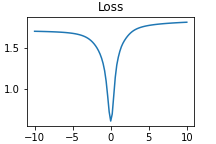
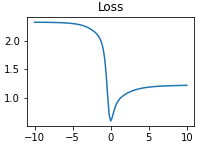
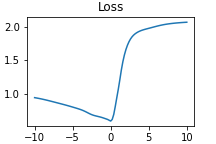
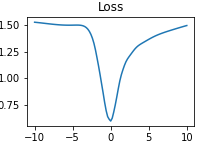
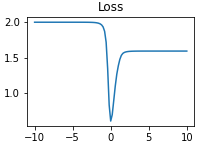
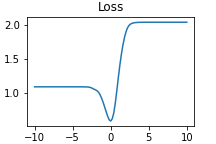
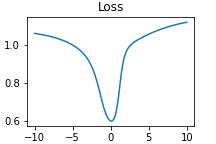
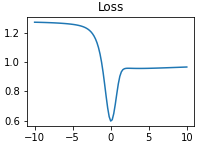
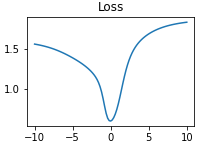
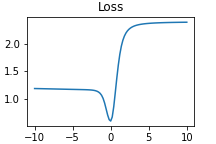
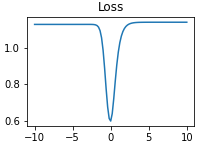
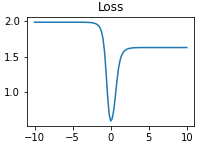
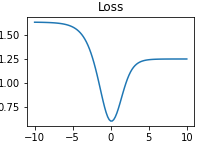
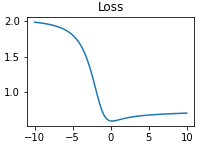
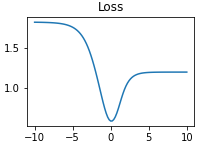
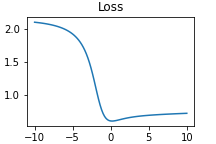
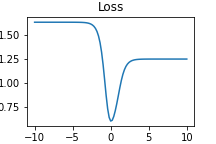
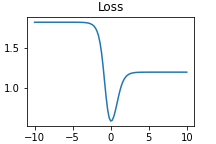
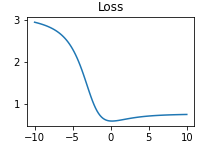
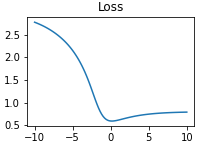
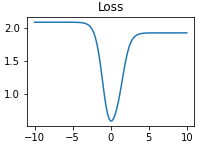

In [12]:
show_loss_surfaces(mlp)

In [13]:
# For Exercise 1, just read and run the code.
data, labels = non_linearly_separable_data()

mlp = torch.nn.Sequential(OrderedDict([
    ('layer1', Sequential(Linear(2, 2), Tanh())),
    ('layer2', Sequential(Linear(2, 2), Tanh())),
    ('layer3', Sequential(Linear(2, 2), Tanh())),
    ('layer4', Sequential(Linear(2, 1), Tanh()))
]))
seeded_net(34, mlp) # Seed the parameters pseudorandomly

history = []
learning_rate = 0.4
for iteration in pbar(range(1000)):
    preds = mlp(data)[:,0]
    loss = ((preds - labels) ** 2).mean()
    grads = torch.autograd.grad(loss, mlp.parameters())
  
    with torch.no_grad():
        accuracy = (preds.sign() == labels).sum().item() / len(labels)
        # Remember a history of network weights, losses, and accuracies
        history.append((deepcopy(mlp), dict(loss=loss.item(), accuracy=accuracy)))
        # Update the network parameters
        for (name, parameter), grad in zip(mlp.named_parameters(), grads):
            parameter -= learning_rate * grad
# Visualize the history.
MLPHistoryWidget(data=data, labels=labels, history=history)


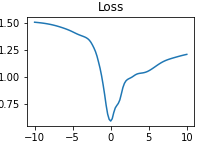
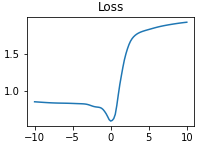
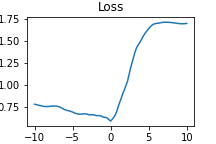
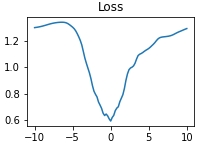
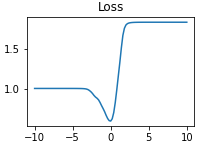
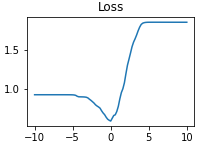
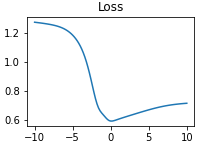
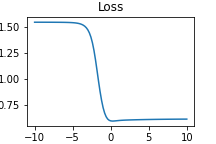
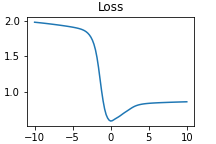
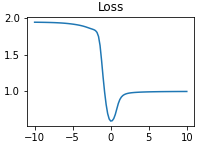
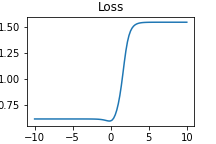
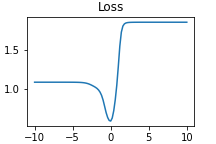
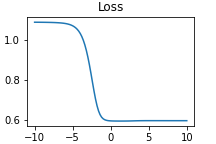
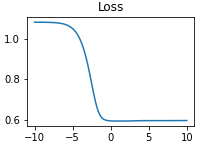
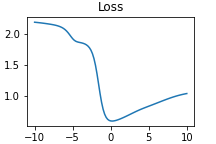
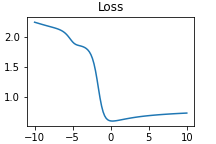
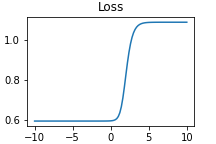
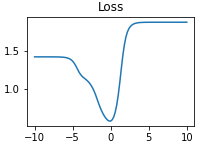
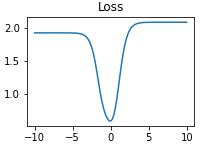
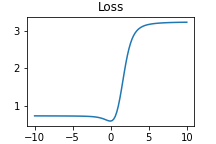
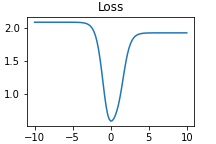

In [14]:
show_loss_surfaces(mlp)

In [15]:
LossSurfaceWidget(mlp, data, labels)

## Exercise 5.  Monitor the gradients

Copy the Exercise 4 code below, and use any seed which is getting stuck for you.

Use code like the following to create a add a list of gradients to the training history. 

```
        gradlog = {name + ' grad': grad.norm().item()
                   for (name, _), grad in zip(mlp.named_parameters(), grads) if 'weight' in name}
        history.append((deepcopy(mlp), dict(loss=loss.item(), accuracy=accuracy, **gradlog)))
```

Do you notice any trends with the gradients during training?   What happens when your training gets stuck?

Sometimes, some layers have very different gradients than other layers.

In [16]:
# For Exercise 1, just read and run the code.
data, labels = non_linearly_separable_data()

mlp = torch.nn.Sequential(OrderedDict([
    ('layer1', Sequential(Linear(2, 2), Tanh())),
    ('layer2', Sequential(Linear(2, 2), Tanh())),
    ('layer3', Sequential(Linear(2, 2), Tanh())),
    ('layer4', Sequential(Linear(2, 1), Tanh()))
]))
seeded_net(34, mlp) # Seed the parameters pseudorandomly

history = []
learning_rate = 0.4
for iteration in pbar(range(1000)):
    preds = mlp(data)[:,0]
    loss = ((preds - labels) ** 2).mean()
    grads = torch.autograd.grad(loss, mlp.parameters())
  
    with torch.no_grad():
        accuracy = (preds.sign() == labels).sum().item() / len(labels)
        # Remember a history of network weights, losses, and accuracies
        gradlog = {name + ' grad': grad.norm().item()
                   for (name, _), grad in zip(mlp.named_parameters(), grads) if 'weight' in name}
        history.append((deepcopy(mlp), dict(loss=loss.item(), accuracy=accuracy, **gradlog)))        # Update the network parameters
        for (name, parameter), grad in zip(mlp.named_parameters(), grads):
            parameter -= learning_rate * grad
# Visualize the history.
MLPHistoryWidget(data=data, labels=labels, history=history)


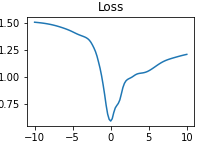
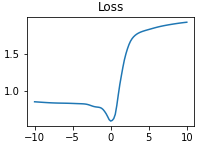
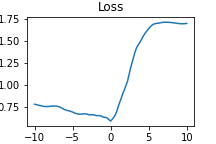
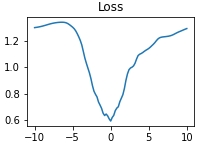
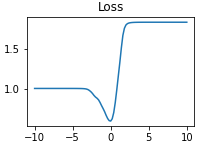
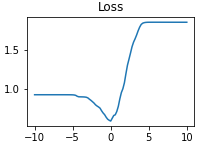
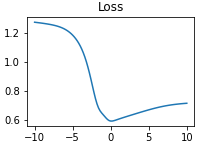
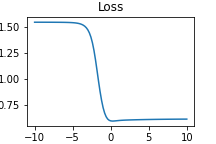
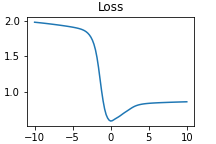
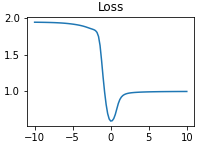
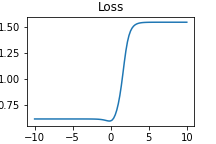
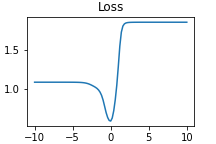
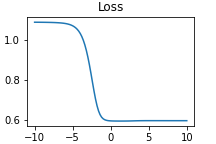
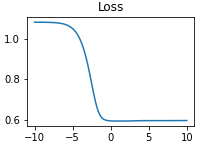
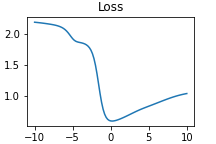
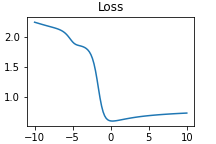
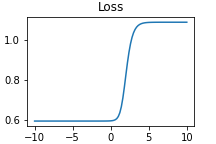
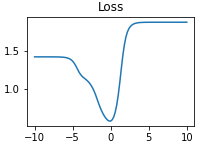
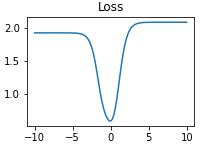
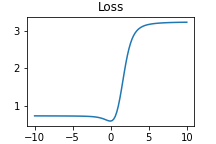
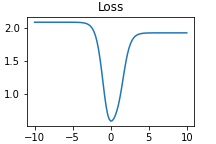

In [17]:
show_loss_surfaces(mlp)

## Exercise 6. Experiment with very deep networks and weight initialization.

[Kaiming He (2015)](https://papers.baulab.info/He-2015.pdf) and [Xavier Glorot (2010)](https://papers.baulab.info/Glorot-2010.pdf) wrote famous papers where they noticed that the scale of the weight initialization was often critical to successful training when the network is deeper than a few layers.  The `seeded_net` function initializes parameters with unit variance, but you can change this.

Do the following:

   1. Make the network 6 layers deep or deeper by copying the early layers and giving them new names.
   2. Monitor gradients as in exercise 4 above
   3. Experiment with larger and smaller weights by adding code like this after `seeded_net`:

```
seeded_net(1, mlp) # Seed the parameters pseudorandomly
with torch.no_grad():
    for parameter in mlp.parameters():
        parameter *= 0.7
```

What is the impact of initialization on initial gradients at iteration 0?

Typically you either have **vanishing gradients** or **exploding gradients** unless initialization is just right.  Which are you seeing with this architecture?

The famous [AlexNet network, Krizhevsky (2012)](https://papers.baulab.info/Krizhevsky-2012.pdf) was 8 layers deep.  Can you get an 8-layer-deep version of this network to train?

In [29]:
# Your code for Exercise 6 here.
# For Exercise 1, just read and run the code.
data, labels = non_linearly_separable_data()

mlp8Layers = torch.nn.Sequential(OrderedDict([
    ('layer1', Sequential(Linear(2, 2), Tanh())),
    ('layer2', Sequential(Linear(2, 2), Tanh())),
    ('layer3', Sequential(Linear(2, 2), Tanh())),
    ('layer4', Sequential(Linear(2, 2), Tanh())),
    ('layer5', Sequential(Linear(2, 2), Tanh())),
    ('layer6', Sequential(Linear(2, 2), Tanh())),
    ('layer7', Sequential(Linear(2, 2), Tanh())),
    ('layer8', Sequential(Linear(2, 1), Tanh()))

]))
seeded_net(1, mlp8Layers) # Seed the parameters pseudorandomly
with torch.no_grad():
    for parameter in mlp8Layers.parameters():
        parameter *= 0.7
history = []
learning_rate = 0.4
for iteration in pbar(range(1000)):
    preds = mlp8Layers(data)[:,0]
    loss = ((preds - labels) ** 2).mean()
    grads = torch.autograd.grad(loss, mlp8Layers.parameters())
  
    with torch.no_grad():
        accuracy = (preds.sign() == labels).sum().item() / len(labels)
        # Remember a history of network weights, losses, and accuracies
        gradlog = {name + ' grad': grad.norm().item()
                   for (name, _), grad in zip(mlp8Layers.named_parameters(), grads) if 'weight' in name}
        history.append((deepcopy(mlp8Layers), dict(loss=loss.item(), accuracy=accuracy, **gradlog)))        # Update the network parameters
        for (name, parameter), grad in zip(mlp8Layers.named_parameters(), grads):
            parameter -= learning_rate * grad
# Visualize the history.
MLPHistoryWidget(data=data, labels=labels, history=history)

## Exercise 7.  Experiment with wide and shallow networks.

[George Cybenko (1989)](https://papers.baulab.info/Cybenko-1989.pdf) and
[Kurt Hornik (1991)](https://papers.baulab.info/also/Hornik-1991.pdf)
wrote famous papers that showed that any continuous function can be approximated using
just a couple layers, if you use enough neurons.

Try training a network with just two layers. How many neurons do you need to get good accuracy?

[Dauphin (2014)](https://papers.baulab.info/also/Dauphin-2014.pdf) has argued that, in practice, when you have a high dimensional network, you do not run into local minima as often (he argues that the main problem is flat saddle points instead).

Do you see any other phenomenon in the shape of the learned function of a wide shallow network that bothers you?

In [28]:
# Your code for Exercise 7 here.
# Your code for Exercise 6 here.
# For Exercise 1, just read and run the code.
data, labels = non_linearly_separable_data()

mlp8Layers = torch.nn.Sequential(OrderedDict([
    ('layer1', Sequential(Linear(2, 10), Tanh())),
    ('layer2', Sequential(Linear(10, 10), Tanh()))
]))
seeded_net(1, mlp8Layers) # Seed the parameters pseudorandomly
with torch.no_grad():
    for parameter in mlp8Layers.parameters():
        parameter *= 0.7
history = []
learning_rate = 0.4
for iteration in pbar(range(1000)):
    preds = mlp8Layers(data)[:,0]
    loss = ((preds - labels) ** 2).mean()
    grads = torch.autograd.grad(loss, mlp8Layers.parameters())
  
    with torch.no_grad():
        accuracy = (preds.sign() == labels).sum().item() / len(labels)
        # Remember a history of network weights, losses, and accuracies
        gradlog = {name + ' grad': grad.norm().item()
                   for (name, _), grad in zip(mlp8Layers.named_parameters(), grads) if 'weight' in name}
        history.append((deepcopy(mlp8Layers), dict(loss=loss.item(), accuracy=accuracy, **gradlog)))        # Update the network parameters
        for (name, parameter), grad in zip(mlp8Layers.named_parameters(), grads):
            parameter -= learning_rate * grad
# Visualize the history.
MLPHistoryWidget(data=data, labels=labels, history=history)

## Exercise 8.  Experiment with networks that are both wide and shallow.

Classical machine learning theory would suggest that the problems you saw in Exercise 6 with very shallow networks with many neurons would get even worse if you added even more neurons on more layers.

However, classical theory does not explain the success of deep networks in this setting.  See [Nakkiran 2019](https://papers.baulab.info/also/Nakkiran-2019.pdf) for a discussion of some of the issues.

Try it out.  Create a network with 8 layers, with 10 hidden dimensions at every layer (except the input of the network should remain 2 dimensional and the output should be one dimensional).

Find a weight initialization and learning rate that seems to be stable.

* Does the network converge to an accurate solution for different weights?
* How does the learned function compare to the functions learned in Exercise 7?

In [32]:
# Your code for Exercise 8 here.
# Your code for Exercise 6 here.
# For Exercise 1, just read and run the code.
data, labels = non_linearly_separable_data()

mlp8Layers = torch.nn.Sequential(OrderedDict([
    ('layer1', Sequential(Linear(2, 10), Tanh())),
    ('layer2', Sequential(Linear(10, 10), Tanh())),
    ('layer3', Sequential(Linear(10, 10), Tanh())),
    ('layer4', Sequential(Linear(10, 10), Tanh())),
    ('layer5', Sequential(Linear(10, 10), Tanh())),
    ('layer6', Sequential(Linear(10, 10), Tanh())),
    ('layer7', Sequential(Linear(10, 10), Tanh())),
    ('layer8', Sequential(Linear(10, 1), Tanh()))

]))
seeded_net(1, mlp8Layers) # Seed the parameters pseudorandomly
with torch.no_grad():
    for parameter in mlp8Layers.parameters():
        parameter *= 0.7
history = []
learning_rate = 0.2
for iteration in pbar(range(1000)):
    preds = mlp8Layers(data)[:,0]
    loss = ((preds - labels) ** 2).mean()
    grads = torch.autograd.grad(loss, mlp8Layers.parameters())
  
    with torch.no_grad():
        accuracy = (preds.sign() == labels).sum().item() / len(labels)
        # Remember a history of network weights, losses, and accuracies
        gradlog = {name + ' grad': grad.norm().item()
                   for (name, _), grad in zip(mlp8Layers.named_parameters(), grads) if 'weight' in name}
        history.append((deepcopy(mlp8Layers), dict(loss=loss.item(), accuracy=accuracy, **gradlog)))        # Update the network parameters
        for (name, parameter), grad in zip(mlp8Layers.named_parameters(), grads):
            parameter -= learning_rate * grad
# Visualize the history.
MLPHistoryWidget(data=data, labels=labels, history=history)

In [33]:
# Your code for Exercise 8 here.
# Your code for Exercise 6 here.
# For Exercise 1, just read and run the code.
data, labels = non_linearly_separable_data()

mlp8Layers = torch.nn.Sequential(OrderedDict([
    ('layer1', Sequential(Linear(2, 10), Tanh())),
    ('layer2', Sequential(Linear(10, 10), Tanh())),
    ('layer3', Sequential(Linear(10, 10), Tanh())),
    ('layer4', Sequential(Linear(10, 10), Tanh())),
    ('layer5', Sequential(Linear(10, 10), Tanh())),
    ('layer6', Sequential(Linear(10, 10), Tanh())),
    ('layer7', Sequential(Linear(10, 10), Tanh())),
    ('layer8', Sequential(Linear(10, 1), Tanh()))

]))
seeded_net(1, mlp8Layers) # Seed the parameters pseudorandomly
with torch.no_grad():
    for parameter in mlp8Layers.parameters():
        parameter *= 0.7
history = []
learning_rate = 0.5
for iteration in pbar(range(1000)):
    preds = mlp8Layers(data)[:,0]
    loss = ((preds - labels) ** 2).mean()
    grads = torch.autograd.grad(loss, mlp8Layers.parameters())
  
    with torch.no_grad():
        accuracy = (preds.sign() == labels).sum().item() / len(labels)
        # Remember a history of network weights, losses, and accuracies
        gradlog = {name + ' grad': grad.norm().item()
                   for (name, _), grad in zip(mlp8Layers.named_parameters(), grads) if 'weight' in name}
        history.append((deepcopy(mlp8Layers), dict(loss=loss.item(), accuracy=accuracy, **gradlog)))        # Update the network parameters
        for (name, parameter), grad in zip(mlp8Layers.named_parameters(), grads):
            parameter -= learning_rate * grad
# Visualize the history.
MLPHistoryWidget(data=data, labels=labels, history=history)

In [34]:
# Your code for Exercise 8 here.
# Your code for Exercise 6 here.
# For Exercise 1, just read and run the code.
data, labels = non_linearly_separable_data()

mlp8Layers = torch.nn.Sequential(OrderedDict([
    ('layer1', Sequential(Linear(2, 10), Tanh())),
    ('layer2', Sequential(Linear(10, 10), Tanh())),
    ('layer3', Sequential(Linear(10, 10), Tanh())),
    ('layer4', Sequential(Linear(10, 10), Tanh())),
    ('layer5', Sequential(Linear(10, 10), Tanh())),
    ('layer6', Sequential(Linear(10, 10), Tanh())),
    ('layer7', Sequential(Linear(10, 10), Tanh())),
    ('layer8', Sequential(Linear(10, 1), Tanh()))

]))
seeded_net(1, mlp8Layers) # Seed the parameters pseudorandomly
with torch.no_grad():
    for parameter in mlp8Layers.parameters():
        parameter *= 0.7
history = []
learning_rate = 0.6
for iteration in pbar(range(1000)):
    preds = mlp8Layers(data)[:,0]
    loss = ((preds - labels) ** 2).mean()
    grads = torch.autograd.grad(loss, mlp8Layers.parameters())
  
    with torch.no_grad():
        accuracy = (preds.sign() == labels).sum().item() / len(labels)
        # Remember a history of network weights, losses, and accuracies
        gradlog = {name + ' grad': grad.norm().item()
                   for (name, _), grad in zip(mlp8Layers.named_parameters(), grads) if 'weight' in name}
        history.append((deepcopy(mlp8Layers), dict(loss=loss.item(), accuracy=accuracy, **gradlog)))        # Update the network parameters
        for (name, parameter), grad in zip(mlp8Layers.named_parameters(), grads):
            parameter -= learning_rate * grad
# Visualize the history.
MLPHistoryWidget(data=data, labels=labels, history=history)